#  Melanoma Skin Cancer Detection

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In this notebook, we will build and train model to detect Melanoma

The solution is divided into the following sections:

1. Data Reading and Understanding
2. Data Preparation
3. Data Visualization
4. Model Building - CNN Model
5. Data Augmentation
6. Model Building on Augmented Data 
7. Class Distribution
8. Class Imbalance Treatment
9. Model Building on balanced data

### Importing all the important libraries

In [24]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import datetime 
import Augmentor
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
keras.__version__

'2.8.0'

In [ ]:
Augmentor.__version__

'0.2.10'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1954303854148774161
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10802686660572179437
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Reading and Understanding

In [45]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True)

Mounted at /content/gdrive


In [46]:
# Defining the path for train and test images
#C:\Users\Nazneen\Downloads\Melanoma_Assignment\CNN_Assignment\Dataset\Train
#train_path="C:/Users/Nazneen/Downloads/Melanoma_Assignment/CNN_Assignment/Dataset/Train/"
#test_path="C:/Users/Nazneen/Downloads/Melanoma_Assignment/CNN_Assignment/Dataset/Test/"
train_path="gdrive/MyDrive/CNN_Assignment/Dataset/Train/"
test_path="gdrive/MyDrive/CNN_Assignment/Dataset/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [47]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Number of Training images :',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Number of Testing images :',image_count_test)

Number of Training images : 2302
Number of Testing images : 118


This dataset has about __2357 images (2239 train , 118 test)__ of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## 2. Data Preparation

In [48]:
#Define Batch Size , image height and width 
batch_size = 32
img_height = 180
img_width = 180

### 2.1 Train Data Set Creation <a name='no2.1' />

Use 80% of the images for training, and 20% for validation.

In [49]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2302 files belonging to 9 classes.
Using 1842 files for training.


In [50]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


<BarContainer object of 9 artists>

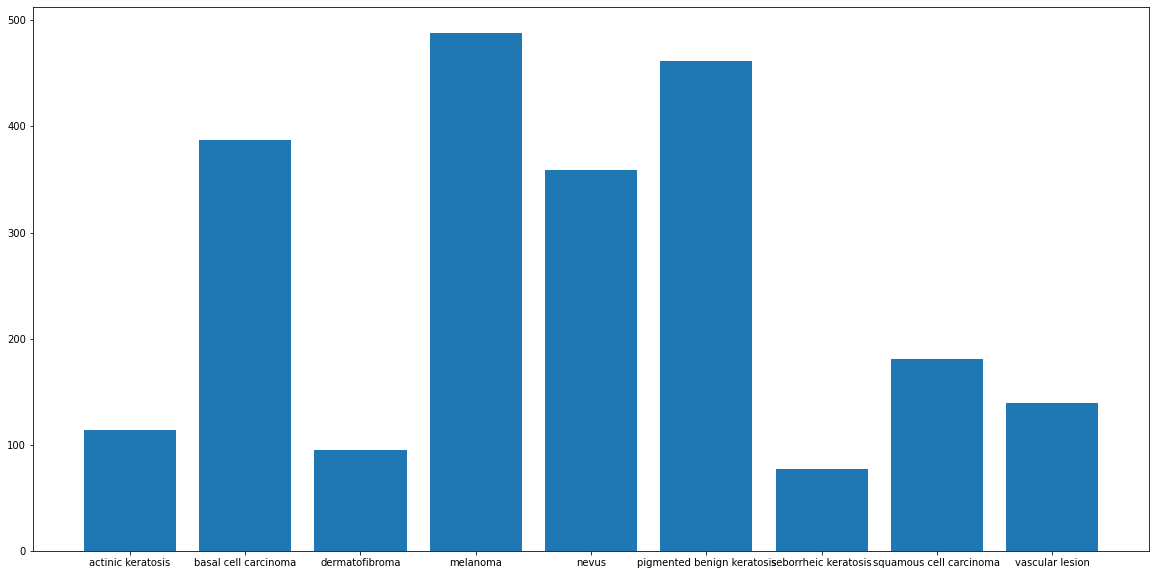

In [51]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(20,10))
plt.bar(class_names,count)

### 2.2 Validation Data Set Creation <a name='no2.2' />

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2302 files belonging to 9 classes.
Using 460 files for validation.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [53]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Data Visualization

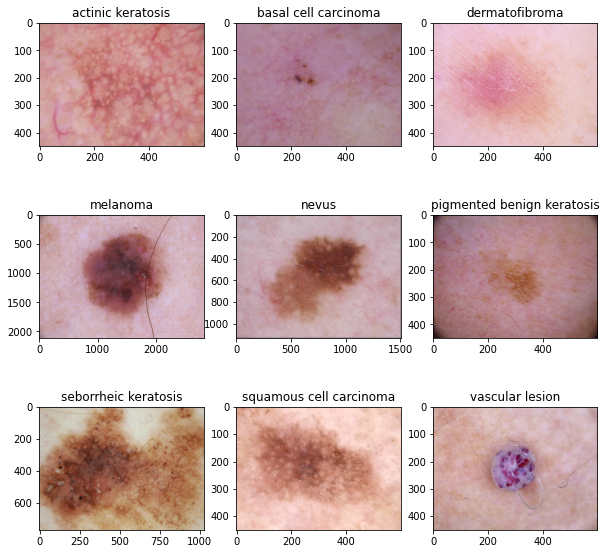

In [54]:
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## 4. Model Building

### 4.1 Create Model

In [55]:
num_classes = 9

In [56]:
initial_model =Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),  
    Dense(num_classes, activation='softmax')
])

### 4.2 Compile Model

In [57]:
def compileModel(model):

  model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
  return model

In [58]:
compileModel(initial_model)

###  4.3 Train Model

In [59]:
def trainModel(model, epochs):
  start_time= datetime.datetime.now()
  print('Start Time ----->',start_time)
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )
  end_time = datetime.datetime.now()
  print('End Time ----->',end_time)
  delta = end_time - start_time
  print('Time Taken to train the model in minutes ----> ', (delta.total_seconds()) / 60)
  return history

In [68]:
epochs = 20
history = trainModel(initial_model, epochs)

Start Time -----> 2022-07-20 16:13:02.137302
Epoch 1/20
58/58 [==============================] - 1s 22ms/step - loss: 0.2645 - accuracy: 0.9001 - val_loss: 2.0143 - val_accuracy: 0.5326
Epoch 2/20
58/58 [==============================] - 1s 22ms/step - loss: 0.2259 - accuracy: 0.9169 - val_loss: 2.2500 - val_accuracy: 0.5478
Epoch 3/20
58/58 [==============================] - 1s 22ms/step - loss: 0.2462 - accuracy: 0.9083 - val_loss: 2.0652 - val_accuracy: 0.5609
Epoch 4/20
58/58 [==============================] - 1s 22ms/step - loss: 0.1851 - accuracy: 0.9229 - val_loss: 2.1946 - val_accuracy: 0.5457
Epoch 5/20
58/58 [==============================] - 2s 27ms/step - loss: 0.1743 - accuracy: 0.9289 - val_loss: 2.0202 - val_accuracy: 0.5239
Epoch 6/20
58/58 [==============================] - 1s 22ms/step - loss: 0.1778 - accuracy: 0.9202 - val_loss: 1.9888 - val_accuracy: 0.5217
Epoch 7/20
58/58 [==============================] - 1s 22ms/step - loss: 0.1975 - accuracy: 0.9273 - val_loss

In [61]:
# View the summary of all layers
def showSummary(model): 
  model.summary()
  return

In [ ]:
showSummary(initial_model)

###  4.4 Visualize the results

In [62]:
def compareAccuracyAndLoss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  return

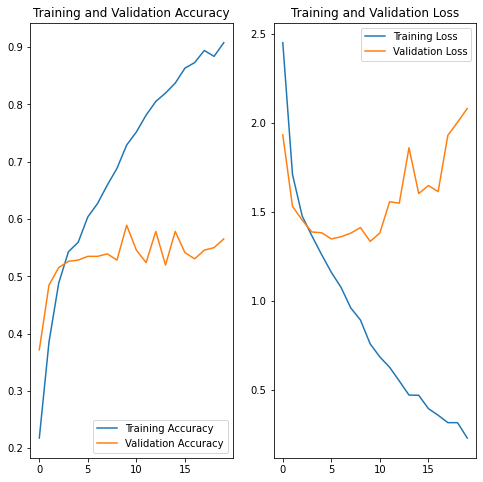

In [63]:
compareAccuracyAndLoss(history)

###  4.5 Observations <a name='no4.5' />

-  The accuracy of the model for the **Training dataset** is **~93%**. However, the **Validation accuracy** is not at par with the training accuracy. 
-  **Validation dataset** accuracy is **~54%**. Also,the validation loss as observed is very high.
-  This huge difference between training and validation accuracies is an indicator of **Overfitting** in the model.
-  We will add some `Dropout` layers, a few more convolution layers, and the `BatchNormalization` layers to overcome overfitting.

### 4.6 Model building to overcome overfitting

In [104]:
updated_model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,), 
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.65),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.4),    
    Dense(num_classes, activation='softmax')
])

In [105]:
compileModel(updated_model)

In [106]:
epochs = 20 
history = trainModel(updated_model, epochs)

Start Time -----> 2022-07-20 16:29:13.944873
Epoch 1/20
58/58 [==============================] - 4s 58ms/step - loss: 2.1199 - accuracy: 0.2383 - val_loss: 2.1759 - val_accuracy: 0.1587
Epoch 2/20
58/58 [==============================] - 3s 55ms/step - loss: 1.6760 - accuracy: 0.4164 - val_loss: 2.3436 - val_accuracy: 0.1587
Epoch 3/20
58/58 [==============================] - 3s 55ms/step - loss: 1.5824 - accuracy: 0.4528 - val_loss: 2.4081 - val_accuracy: 0.1587
Epoch 4/20
58/58 [==============================] - 3s 55ms/step - loss: 1.4797 - accuracy: 0.4864 - val_loss: 2.2651 - val_accuracy: 0.2000
Epoch 5/20
58/58 [==============================] - 3s 55ms/step - loss: 1.4178 - accuracy: 0.5005 - val_loss: 2.1838 - val_accuracy: 0.1978
Epoch 6/20
58/58 [==============================] - 3s 55ms/step - loss: 1.4099 - accuracy: 0.5228 - val_loss: 1.9252 - val_accuracy: 0.2891
Epoch 7/20
58/58 [==============================] - 3s 55ms/step - loss: 1.3535 - accuracy: 0.5331 - val_loss

In [ ]:
showSummary(updated_model)

In [ ]:
compareAccuracyAndLoss(history)

-  The accuracy of the model for the **Training dataset** is **~67%**. 
-  **Validation dataset** accuracy is **~51%**.
-  The updated model as compared to the initial one seems to perform better and also reduced overfitting to come extent.


##  5. Data Augmentation 

###  5.1 Define the Augmentation

In [107]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

###  5.2 Visualize the Augmented Data

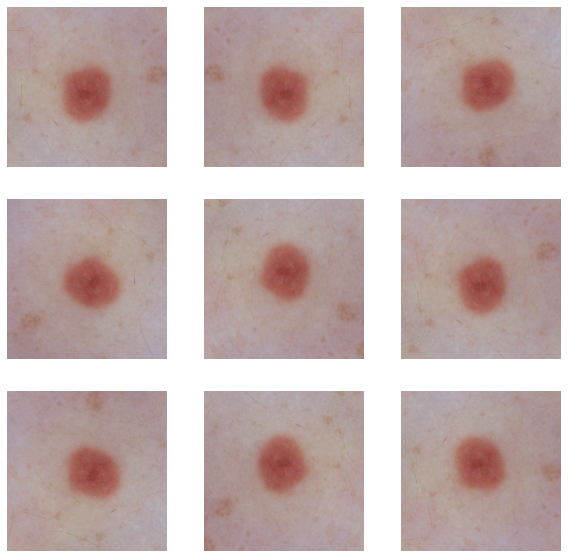

In [108]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  aug_img=np.array(augmented_image[0],np.int32)  
  plt.imshow((aug_img))
  plt.axis("off")

## 6. Model Building on Augmented Data

###  6.1 Create Model

In [113]:
augmented_model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,), 
    data_augmentation,
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.25),    
    Dense(9, activation='softmax')
])

### 6.2 Compile Model

In [114]:
compileModel(augmented_model)

### 6.3 Train Model

In [115]:
epochs = 20
history = trainModel(augmented_model, epochs)

Start Time -----> 2022-07-20 16:33:45.233767
Epoch 1/20
58/58 [==============================] - 5s 61ms/step - loss: 2.0883 - accuracy: 0.2345 - val_loss: 2.1789 - val_accuracy: 0.1587
Epoch 2/20
58/58 [==============================] - 3s 58ms/step - loss: 1.7157 - accuracy: 0.3822 - val_loss: 2.1880 - val_accuracy: 0.1804
Epoch 3/20
58/58 [==============================] - 3s 58ms/step - loss: 1.6216 - accuracy: 0.4104 - val_loss: 2.1618 - val_accuracy: 0.2000
Epoch 4/20
58/58 [==============================] - 3s 58ms/step - loss: 1.5546 - accuracy: 0.4571 - val_loss: 2.1836 - val_accuracy: 0.1978
Epoch 5/20
58/58 [==============================] - 3s 57ms/step - loss: 1.5466 - accuracy: 0.4609 - val_loss: 1.8700 - val_accuracy: 0.3609
Epoch 6/20
58/58 [==============================] - 3s 58ms/step - loss: 1.5305 - accuracy: 0.4549 - val_loss: 2.0937 - val_accuracy: 0.2087
Epoch 7/20
58/58 [==============================] - 3s 58ms/step - loss: 1.5136 - accuracy: 0.4745 - val_loss

In [116]:
showSummary(augmented_model)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_24 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_22 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_138 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_139 (Conv2D)         (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                

### 6.4 Visualize the results

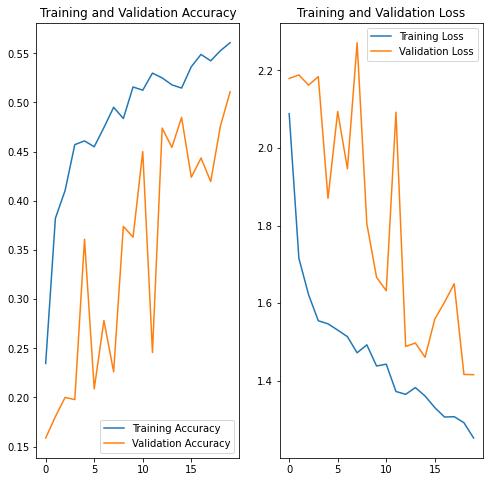

In [117]:
compareAccuracyAndLoss(history)

### 6.5  Observations 

-  The model accuracy for **Train data set** has gone up to nearly **56%**.
-  The accuracy for the **Validation set** is also at **51%**.
-  This is a much better model compared to the previous two models as there seems to be **No Overfitting**.
-  `Data Augmentation` has improved the model performance.

## 7. Check Class Imbalance

In [119]:
for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 387 samples.
dermatofibroma has 95 samples.
melanoma has 488 samples.
nevus has 359 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


<BarContainer object of 9 artists>

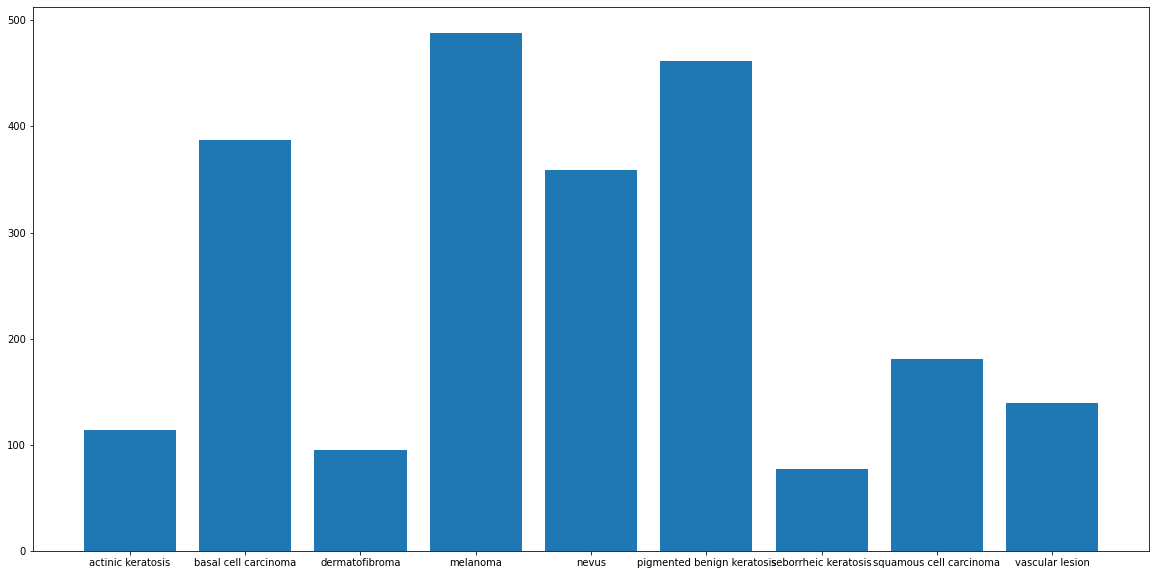

In [121]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(20,10))
plt.bar(class_names,count)

-  The samples of various classes are not in equal proportion.
-  There is a significant **Class Imbalance** observed.
-  The class with the least number of samples is `Seborrheic Keratosis` with **77**.
-  The class that dominates the data in terms of proportionate number of samples is `Pigmented Benign Keratosis` with sample size of **462**. 

## 7. Class Imbalance Treatment

### 7.1 Using Augmentor 

In [122]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.75, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5B7D6AD2D0>: 100%|██████████| 500/500 [00:19<00:00, 26.27 Samples/s]


Initialised with 387 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CF2ADF1D0>: 100%|██████████| 500/500 [00:19<00:00, 25.52 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CF2AFA290>: 100%|██████████| 500/500 [00:20<00:00, 24.95 Samples/s]


Initialised with 488 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5CF28660D0>: 100%|██████████| 500/500 [01:39<00:00,  5.03 Samples/s]


Initialised with 359 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F5B7D6B7510>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CF2BAB510>: 100%|██████████| 500/500 [00:18<00:00, 26.49 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5B7D6790D0>: 100%|██████████| 500/500 [00:43<00:00, 11.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CF2AE91D0>: 100%|██████████| 500/500 [00:18<00:00, 27.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CF03B5D90>: 100%|██████████| 500/500 [00:18<00:00, 26.83 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [123]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [124]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [125]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [126]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [137]:
class_count=[]
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')
    class_count.append(length_tot)

actinic keratosis has 614 samples.
basal cell carcinoma has 887 samples.
dermatofibroma has 595 samples.
melanoma has 988 samples.
nevus has 859 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


<BarContainer object of 9 artists>

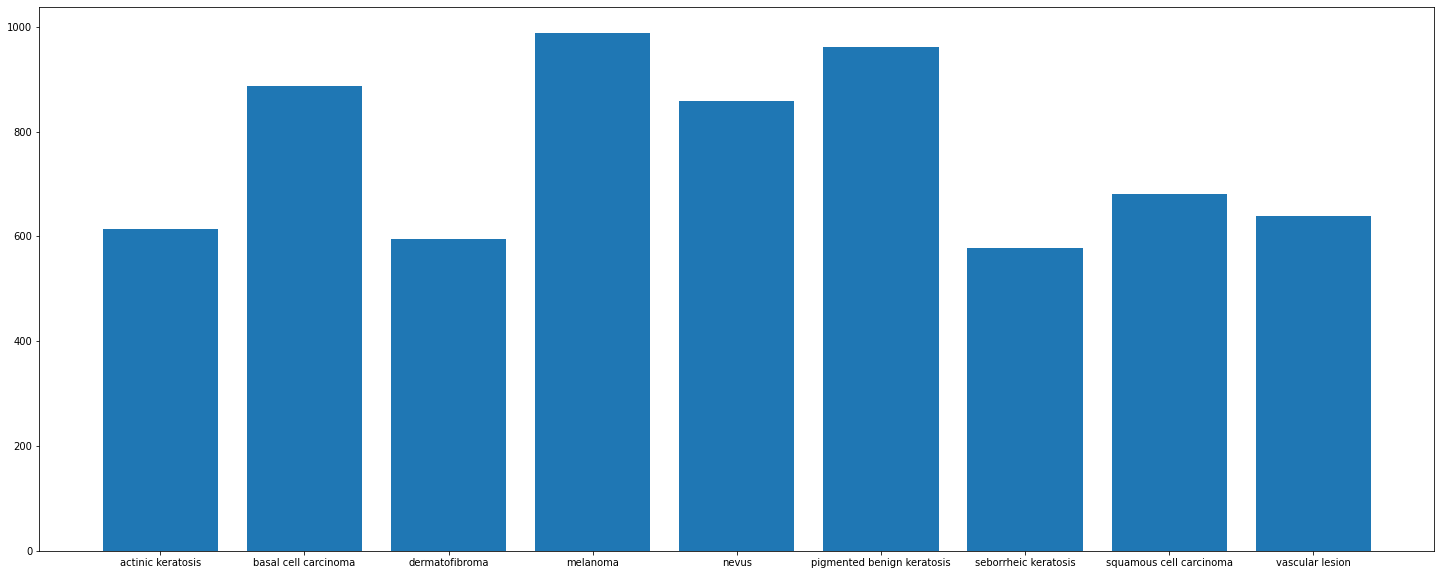

In [138]:
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

### 7.3 Observations <a name='no9.3' />

-  The Augmentor has **helped decrease the imbalance** in class images and that can be viewed from above.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##  8. Model Building on Balanced Dataset

### 8.1 Create Train and Validation Dataset

In [129]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6802 files belonging to 9 classes.
Using 5442 files for training.


In [130]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6802 files belonging to 9 classes.
Using 1360 files for validation.


### 8.2 Create Model

In [145]:
final_model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),     
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.15),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5),    
    Dense(num_classes, activation='softmax')
])

### 8.3 Compile Model

In [146]:
compileModel(final_model)

### 8.4 Train the Model

In [147]:
epochs = 30
history = trainModel(final_model, epochs)

Start Time -----> 2022-07-20 17:50:11.028417
Epoch 1/30
171/171 [==============================] - 34s 188ms/step - loss: 1.9238 - accuracy: 0.2604 - val_loss: 2.2182 - val_accuracy: 0.1397
Epoch 2/30
171/171 [==============================] - 33s 184ms/step - loss: 1.6865 - accuracy: 0.3686 - val_loss: 2.3610 - val_accuracy: 0.1794
Epoch 3/30
171/171 [==============================] - 32s 183ms/step - loss: 1.5399 - accuracy: 0.4193 - val_loss: 1.8549 - val_accuracy: 0.3235
Epoch 4/30
171/171 [==============================] - 32s 183ms/step - loss: 1.4766 - accuracy: 0.4506 - val_loss: 1.3472 - val_accuracy: 0.4838
Epoch 5/30
171/171 [==============================] - 32s 182ms/step - loss: 1.4226 - accuracy: 0.4691 - val_loss: 1.4927 - val_accuracy: 0.4206
Epoch 6/30
171/171 [==============================] - 32s 183ms/step - loss: 1.2752 - accuracy: 0.5141 - val_loss: 1.5453 - val_accuracy: 0.4507
Epoch 7/30
171/171 [==============================] - 32s 181ms/step - loss: 1.1580 -

In [139]:
showSummary(final_model)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_26 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_150 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_23 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_151 (Conv2D)         (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_95 (Dropout)        (None, 89, 89, 32)      

###  8.5 Visualize the model results 

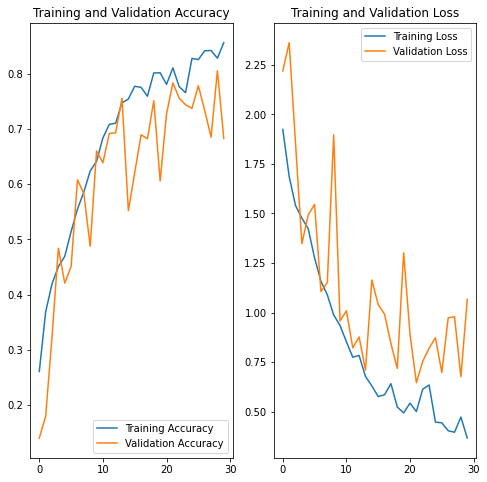

In [148]:
compareAccuracyAndLoss(history)

### 8.6 Observations 

-  The training accuracy seems to be nearly **~86%**. 
-  The validation accuracy is nearly **~80%**.
-  Though the model accuracy has improved, the **class rebalance** has helped **treat the overfitting to some extent**.
-  Much better models could be built or tried out using **more epochs, adding more layers with Dropouts**.